# Домашнее задание шестого урока.

Применим знания на практике: с помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

* ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

**1. Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.**

In [129]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [10]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [16]:
query = """
SELECT count(*)
FROM ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,count()
0,85207


**2. Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:**

* price – цена за ночь
* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

**Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.**

In [31]:
query = """
SELECT room_type, toFloat32(replaceRegexpAll(price, '[$,]', '')) as price
FROM ldn_listings
ORDER BY id
LIMIT 1000
"""
query2 = ph.read_clickhouse(query, connection=connection)
query2

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [32]:
query2.groupby('room_type').price.describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,443.0,153.182846,149.768158,23.0,90.0,120.0,160.00,2000.0
Hotel room,2.0,134.000000,65.053825,88.0,111.0,134.0,157.00,180.0
Private room,551.0,66.820328,78.609314,12.0,35.5,49.0,70.00,1000.0
Shared room,4.0,61.250000,70.244217,20.0,21.5,29.5,69.25,166.0


Ответ: Private room 70.00

**3. К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.**

Hint: toFloat32OrNull(столбец)

Д**авайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.**

**Исходная таблица должна выглядеть так:**


| room_type       | price      |review_scores_rating|
|-----------------|------------|--------------------|
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

**Среди представленных ниже графиков выберите корректный:**

![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7851/image.png)



In [47]:
#сказали дополнительно к имеющимся только рейтинг
#но запрашиваемый рейтинг идет к другим комнатам
#а не к тем которые уже выгрузили
query = """
SELECT room_type, toFloat32(replaceRegexpAll(price, '[$,]', '')) as price,
toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM ldn_listings
WHERE review_scores_rating IS NOT NULL
LIMIT 1000
"""
query3 = ph.read_clickhouse(query, connection=connection)
query3

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [88]:
gp_by_room_means = query3.groupby('room_type').agg({'price': 'mean', 'review_scores_rating': 'mean'})
gp_by_room_means

,price,review_scores_rating
room_type,,
Entire home/apt,135.882950,93.568787
Hotel room,134.000000,92.500000
Private room,54.642437,94.766205
Shared room,21.000000,90.000000


<Axes: xlabel='price', ylabel='review_scores_rating'>

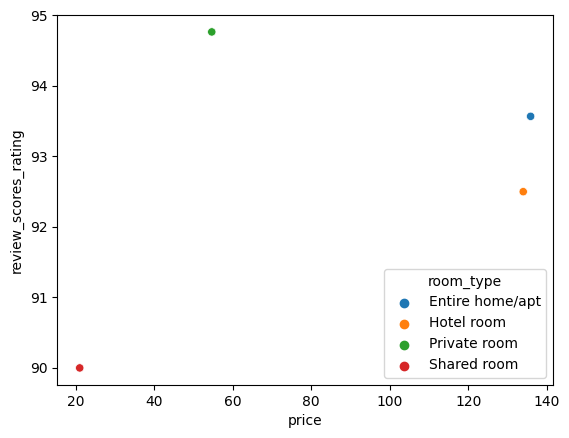

In [93]:
sns.scatterplot(x='price', y='review_scores_rating', hue='room_type',
                data=gp_by_room_means)
    

* 3
* **2**
* 1
* 4

**4. Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.**

**Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:**

* host_id – идентификатор хозяина (уникальный)
* host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта:

"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [113]:
#для запроса без DISTINCT
#sum(query4.groupby('host_id').host_verifications.nunique())==query4.host_id.nunique()
#got True
#вывод: на каждый id приходится 1 уникальный список верификаций
#когда делаем DISTINCT - ничего не теряем

True

In [147]:
query = """
SELECT DISTINCT host_id,
host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
query4 = ph.read_clickhouse(query, connection=connection)
query4.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [119]:
#внутри sql конвертить в лист сложнее
#[1:-2].split(',') 
#
#

"'email', 'phon"

In [149]:
query4['host_verifications'] = query4.host_verifications \
                                .str[1:-2].str.replace("'",'') \
                                          .str.split(', ') 
query4.head()
#.apply(lambda x: x.strip(']').strip('[').replace('\'', '').split(', '))

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."


In [150]:
query4.explode('host_verifications').host_verifications.value_counts()

host_verifications
phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: count, dtype: int64

Ответ: 34

**5. Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.**

**Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.**


| neighbourhood_cleansed | experiences_offered | experiences_count |
|------------------------|---------------------|-------------------|
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |


**Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True).**

**Какой график получился?**

![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7853/image2.png)

In [157]:
query = """
SELECT 
   id
FROM ldn_listings
"""
query5 = ph.read_clickhouse(query, connection=connection)
query5.head()

,id
0,13913
1,15400
2,17402
3,17506
4,25023


In [153]:
query5.id.nunique()

85207

In [155]:
query5.size
#все id объявлений уникальны 

85207

In [163]:
query = """
SELECT 
   neighbourhood_cleansed,
   experiences_offered,
   COUNT(*) AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
query5 = ph.read_clickhouse(query, connection=connection)
query5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [172]:
q5pivot = query5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
q5pivot.fillna(0).head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0


<Axes: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

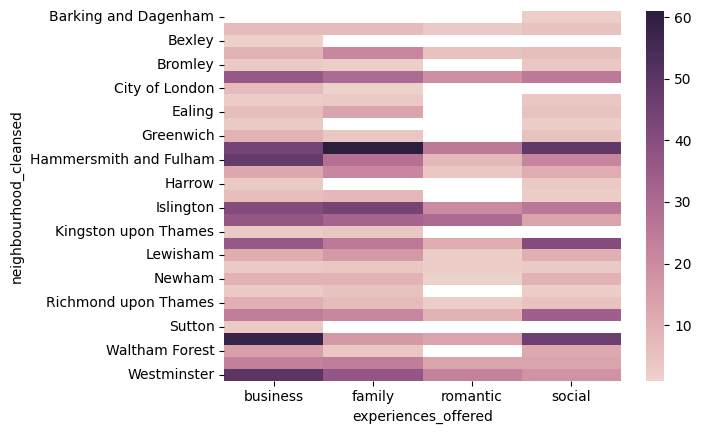

In [174]:
sns.heatmap(q5pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [ ]:
#ОТВЕТ - 1

<Axes: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

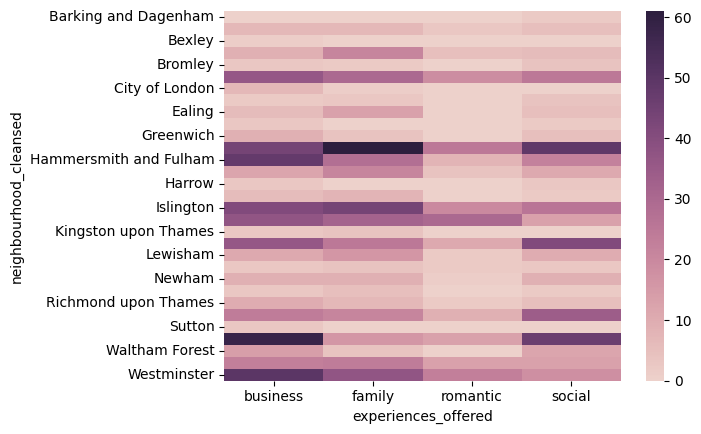

In [175]:
#можно еще NA занулить
sns.heatmap(q5pivot.fillna(0), cmap=sns.cubehelix_palette(as_cmap=True))

* **1**
* 3
* 4
* 2

**6. Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:**

* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* price – цена за ночь 
* experiences_offered – вид доступного впечатления (оставить не 'none')

**Пример части результирующей таблицы:**


| room_type       | price_corr |
|-----------------|------------|
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |

Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

**Далее постройте два графика, используя distplot из библиотеки seaborn:**

* На первом отобразите исходные распределения цен для каждого типа жилья
* На втором – логарифмированные значения (np.log())

Среди представленных графиков выберите два соответствующих.
![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7854/image.png)

In [6]:
query = """
SELECT 
   toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
   room_type
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
query6 = ph.read_clickhouse(query, connection=connection)
query6

,price_corr,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,150.0,Private room
3,45.0,Private room
4,25.0,Private room
...,...,...
1543,100.0,Entire home/apt
1544,125.0,Entire home/apt
1545,185.0,Entire home/apt
1546,110.0,Entire home/apt


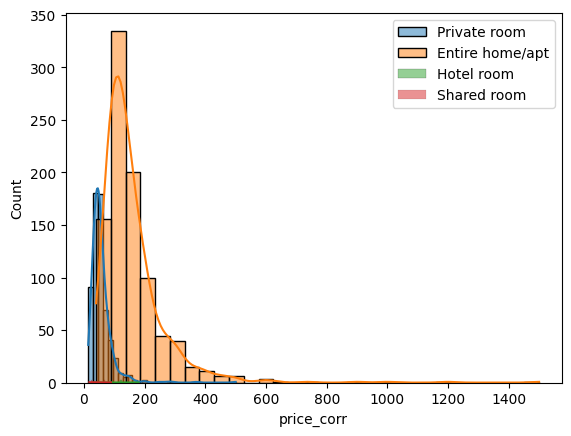

In [47]:
fig, ax = plt.subplots()
for rtype in query6.room_type.unique():
    sns.histplot(query6[query6.room_type==rtype].price_corr, 
                kde=True, bins=30, ax=ax,
                label=rtype)
plt.legend()

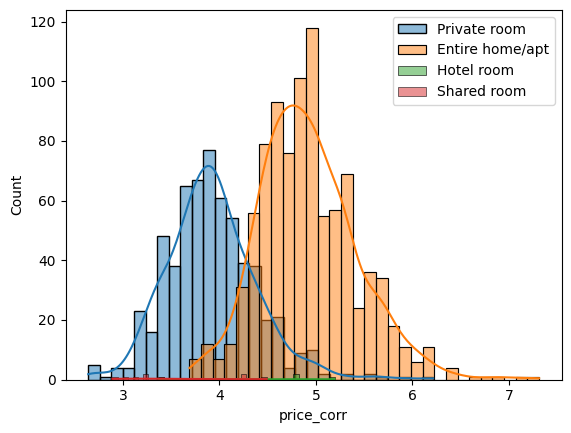

In [48]:
fig, ax = plt.subplots()
for rtype in query6.room_type.unique():
    sns.histplot(query6[query6.room_type==rtype].price_corr.apply(lambda x: np.log(x)), 
                kde=True, bins=30, ax=ax, 
                label=rtype)
plt.legend()

* **3**
* 4
* 1
* 2
* 5
* **6**

**7. Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:**

* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* price – цена за ночь
* first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

**Ограничение поставьте на 1000 строк.**

**Пример результирующей таблицы:**


| room_type       | price_corr |first_review|
|-----------------|------------|------------|
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |


**Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.**

**Пример датафрейма, который будет служить основой для графика:**


| room_type       | avg_price  | year       |
|-----------------|------------|------------|
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |


Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции.

**Среди представленных ниже графиков выберите корректный.**

![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7855/image.png)

In [67]:
query = """
SELECT 
   room_type,
   toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
   first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
query7 = ph.read_clickhouse(query, connection=connection)
query7

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [69]:
# from datetime import datetime

# query7["first_review"] = pd.to_datetime(query7.first_review)
# year = date.year
query7["first_review"] = query7.first_review.str[0:4]

In [81]:
gp = query7.groupby(['room_type', 'first_review'], as_index=False) \
.aggregate({'price': 'mean'})
gp.head()

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328


<Axes: xlabel='first_review', ylabel='price'>

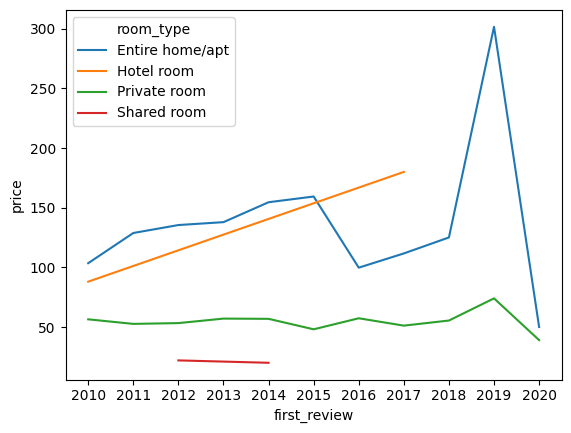

In [84]:
#for rtype in query6.room_type.unique():
sns.lineplot(data=gp, x='first_review', y='price', hue='room_type')

* **1**
* 4
* 3
* 2